<a href="https://colab.research.google.com/github/gggggeun/study/blob/main/IMDB(%EC%98%81%ED%99%94%EB%A6%AC%EB%B7%B0%EB%B6%84%EB%A5%98_%EC%97%B0%EC%8A%B5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[케라스 창시자에게 배우는 딥러닝] 참고

# 영화 리뷰 분류 : IMDB 데이터셋

2종 분류(two-class classification) 또는 이진 분류(binary classification)는 아마 가장 널리 적용된 머신 러닝 문제일 것입니다. 이 예제에서 리뷰 텍스트를 기반으로 영화 리뷰를 긍정(positive)과 부정(nagative)으로 분류하는 방법을 연습해 보겠습니다.

IMDB 데이터셋도 케라스에 포함되어 있으며, 이 데이터는 전처리되어 있어 각 리뷰(단어 시퀀스)가 숫자 시퀀스로 변환되어 있습니다. 여기서 각 숫자는 사전에 있는 고유한 단어를 나타냅니다.

## 데이터 불러오기

In [1]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000) #자주나타나는 단어 1만개만 사용

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [2]:
# 리뷰의 목록. 각 리뷰= 단어 인덱스의 리스트(단어시퀀스가 인코딩됨)
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [3]:
# 0 = 부정, 1 = 긍정
train_labels[0]

1

In [4]:
max([max(sequence) for sequence in train_data])

9999

In [5]:
#decoded_review

word_index = imdb.get_word_index()  #wrod_index는 단어와 정수 인덱스를 매핑한 딕셔너리이다.
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])   # 정수 인덱스와 단어를 매핑하도록 뒤집는다.
decoded_review = ' '.join(
    [reverse_word_index.get(i - 3, '?') for i in train_data[0]])   # ? : 리뷰를 디코딩함. 0,1,2는 '패딩', '문서 시작', '사전에 없음'을 위한 인덱스 이므로 3을 뺀다.

## 데이터 전처리 (인코딩)

신경망에 숫자 리스트를 주입할 수 없기 때문에 리스트를 텐서로 바꿔야 한다. 두 가지 방법이 있다.

- 방법1 : 같은 길이가 되도록 리스트에 패딩(padding)을 추가하고 (samples, sequence_length) 크기의 정수 텐서로 변환한다. (가장 긴 리뷰는 2,494개의 단어이므로 훈련데이터를 변환한 텐서의 크기는 (25000, 2494)이다.) 그 다음 이 정수 텐서를 다룰 수 있는 층을 신경망의 첫 번째 층으로 사용한다.(Embedding층을 말한다.)

- 방법2 : 리스트를 원-핫 인코딩(one-hot encoding)하여 0과 1의 벡터로 변환한다. 예를 들어 시퀀스 [3,5]를 인덱스 3과 5의 위치는 1이고 그 외는 모두 0인 10,000차원의 벡터로 각각 변환한다. (리스트가 하나의 벡터로 변환되므로 훈련 데이터를 변환한 텐서의 크기는 (25000, 10000)가 된다.) 그 다음 부동 소수 벡터 데이터를 다룰 수 있는 Dense 층을 신경망의 첫 번째 층으로 사용한다.


In [6]:
# 방법2 - 원핫인코딩

import numpy as np

def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))  #크기가 (len(sequences), dimension)이고 모든 원소가 0인 행렬을 만든다.
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.  #results[i]에서 특정 인덱스의 위치를 1로 만든다.
  return results
  
x_train = vectorize_sequences(train_data)  # 데이터를 벡터로 변환_train = vectorize_sequences(train_data)  # 데이터를 벡터로 변환
x_test = vectorize_sequences(test_data)

In [7]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [8]:
len(x_train[0])

10000

In [9]:
# 레이블 벡터로 변환

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

## 신경망 모델

- 입력데이터 = 벡터
- 레이블 = 스칼라(1 or 0)
- 이런 문제엔 relu 활성화 함수를 사용한 와넌 연결 층의 네트워크가 잘 작동함.
- 첫번째 dense층에 전달한 매개변수는 은닉 유닛(hidden unit)의 개수이다. 하나의 은닉 유닛은 층이 나타내는 표현 공간에서 하나의 차원이 된다. 16개의 은닉 유닛이 있다는 것은 가중치 행렬 W의 크기가 (input_dimension, 16)이라는 뜻이다. 입력데이터와 W를 점곱하면 입력 데이터가 16차원으로 표현된 공간으로 투영된다.(그리고 편향 벡터b를 더하고 relu연산 적용)
- 은닉 유닛을 늘리면 신경망이 더욱 복잡한 표현을 학습할 수 있지만, 계산 비용이 커지고 원하지 않는 패턴을 학습할 수도 있다. (훈련데이터에서는 성능이 향상되지만, 테스트 데이터에서는 그렇지 않은 과적합현상 발생.)

**활성화 함수가 필요한 이유**

relu와 같은 활성화 함수(또는 비선형성(non-linearity))가 없다면 Dense층은 선형적인 연산인 점곱과 덧셈 2개로 구성된다.
```
output = dot(W, input) + b
```
그러므로 이 층은 입력에 대한 선형 변환(아핀 변환)만을 학습할 수 있다. 이 층의 가설 공간은 입력 데이터를 16차원의 공간으로 바꾸는 가능한 모든 선형 변환의 집합이다. 이런 가설 공간은 매우 제약이 많으며, 선형 층을 깊게 쌓아도 여전히 하나의 선형 연산이기 때문에 층을 여러 개로 구성하는 장점이 없다. 즉, 층을 추가해도 가설 공간이 확장되지 않는다.

가설 공간을 풍부하게 만들어 층을 깊게 만드는 장점을 살리기 위해서는 비선형성 또는 활성화 함수를 추가해야 한다. relu는 딥러닝에서 가장 인기 있는 활성화 함수이다. 비슷한 것으로 prelu, elu 등 이 있다.

In [10]:
# 16개의 은닉 유닛을 가진 2개의 은닉층
# 현재 리뷰의 감정을 스칼라 값의 예측으로 출력하는 세 번째 층
# 은닉층 활성화 함수 relu(음수는 0), 출력층 활성화 함수 sigmoid(0~1 사이의 점수)


from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

## 손실함수와 옵티마이저

이진 분류 문제이고 신경망의 출력이 확률이기 때문에(네트워크의 끝에 시그모이드 활성화 함수를 사용한 하나의 유닛으로 된 층을 놓았다.) biniary_crossentropy 손실이 적합하다. 이 함수가 유일한 선택은 아니고 mean_squared_error도 사용할 수 있다. 확률을 출력하는 모델을 사용할 때는 크로스엔트로피가 최선의 선택이다. 

**크로스엔트로피(crossentropy)**는 정보 이론(Information Theory) 분야에서 온 개념으로 확률 분포 간의 차이를 측정한다. 여기에서는 **원본 분포와 예측 분포 사이를 측정**한다.

In [11]:
model.compile(optimizer = "rmsprop",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

케라스에 rmsprop, binary_crossentropy, accuracy가 포함되어 있기 떄문에 옵티마이저, 손실함수, 측정 지표를 문자열로 지정하는 것이 가능하다. 이따금 옵티마이저의 매개변수를 바꾸거나 자신만의 손실 함수, 측정 함수를 전달해야 할 경우가 있다. 전자의 경우에는 옵티마이저 파이썬 클래스를 사용해 객체를 직접 만들어 optimizer 매개변수에 전달하면 된다. 후자의 경우 loss와 metrics 매개변수에 함수 객체를 전달하면 된다.

In [12]:
#옵티마이저 파이썬 클래스를 사용해 객체를 직접 만들어 optimizer 매개변수에 전달

from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
# loss와 metrics 매개변수에 함수 객체 전달
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss = losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

## 훈련 검증

검증 세트 만들기

In [14]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [15]:
x_val.shape

(10000, 10000)

In [16]:
partial_x_train.shape

(15000, 10000)

이제 모델을 512개의 샘플씩 미니 배치를 만들어 20번의 에포크 동안 훈련시킨다. (x_train과 y_train 텐서에 있는 모든 샘플에 대해 20번 반복한다.)
동시에 따로 떼어 놓은 1만 개의 샘플에서 손실과 정확도를 측정할 것이다. 이렇게 하려면 validation_data 매개변수에 검증 데이터를 전달해야 한다.

정확도를 지정할 때 'accuracy' 또는 'acc' 모두 가능하다. 이렇게 하면 자동으로 이진 분류에는 metrics.binary_accuracy 함수가 되고, 다중 분류에는 metrics.categorical_accuracy함수가 된다. 

In [17]:
model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics=['acc'])
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 3s 60ms/step - loss: 0.5866 - acc: 0.7100 - val_loss: 0.3780 - val_acc: 0.8715
Epoch 2/20
30/30 [==============================] - 1s 36ms/step - loss: 0.3144 - acc: 0.9049 - val_loss: 0.3029 - val_acc: 0.8879
Epoch 3/20
30/30 [==============================] - 1s 37ms/step - loss: 0.2210 - acc: 0.9334 - val_loss: 0.2816 - val_acc: 0.8890
Epoch 4/20
30/30 [==============================] - 1s 36ms/step - loss: 0.1699 - acc: 0.9486 - val_loss: 0.2790 - val_acc: 0.8881
Epoch 5/20
30/30 [==============================] - 1s 36ms/step - loss: 0.1389 - acc: 0.9565 - val_loss: 0.2825 - val_acc: 0.8886
Epoch 6/20
30/30 [==============================] - 1s 35ms/step - loss: 0.1093 - acc: 0.9680 - val_loss: 0.3030 - val_acc: 0.8848
Epoch 7/20
30/30 [==============================] - 1s 36ms/step - loss: 0.0970 - acc: 0.9698 - val_loss: 0.3132 - val_acc: 0.8816
Epoch 8/20
30/30 [==============================] - 1s 36ms/step - loss: 0.0752 - a

CPU를 사용해도 에폭마다 2초도 안걸린다. 전체 훈련은 20초 이상 정도 걸린다. 에포크가 끝날 때마다 1만 개의 검증 샘플 데이터에서 손실과 정확도를 계산하기 때문에 약간씩 지연된다.

model.fit() 메서드는 History 객체를 반환한다. 이 객체는 훈련하는 동안 발생한 모든 정보를 담고 있는 딕셔너리인 history속성을 가지고 있다.

history.history 딕셔너리에 있는 측정지표의 키는 정확도일 경우 'acc', 크로스엔트로피의 경우 'ce' 사용

In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

이 딕셔너리 훈련과 검증하는 동안 모니터링할 측정 지표당 하나씩 모두 4개의 항목을 담고 있다. 이어지는 두 목록에서 맷플롯립을 사용해 훈련과 검증 데이터에 대한 손실과 정확도를 그린다.

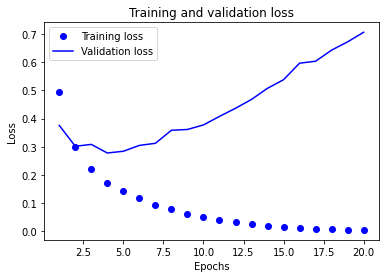

In [20]:
# 훈련(epochs) & 검증 손실
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label="Training loss")  #bo = 파란색 점
plt.plot(epochs, val_loss, 'b', label="Validation loss")   #b = 파란색 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

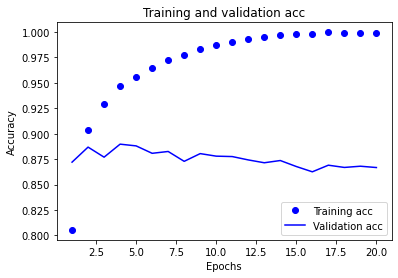

In [21]:
# 훈련(ehochs) & 검증 정확도

plt.clf()   # 그래프 초기화
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label="Training acc")
plt.plot(epochs, val_acc, 'b', label="Validation acc")
plt.title("Training and validation acc")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


훈련 손실이 에포크마다 감소하고 훈련 정확도는 에포크마다 증가한다. 경사 하강법 최적화를 사용했을 때 반복마다 최소화되는 것이 손실이므로 기대했던 대로다. 하지만 검증 손실과 정확도는 성능이 좋지 않다. 4번째 에포크 부터 loss와 정확도의 그래프가 역전되는 것 같다. 

이처럼 훈련 세트에서 잘 작동하는 모델이 처음 보는 데이터에서는 잘 작동하지 않을 수 있다. 이런 현상을 '과대적합(overfitting)' 되었다고 한다.

두번째 에포크 이후부터 훈련 데이터에 과도하게 최적화되어 훈련 데이터에 특화된 표현을 학습하므로 훈련 세트 이외의 데이터에는 일반화되지 못한다.

이런 경우 과대적합을 방지하기 위해 세 번째 에포크 이후에 훈련을 중지할 수 있다. 또는 과대적합을 완화하는 다양한 종류의 기술을 사용하는 방법이 있다.

In [22]:
# epochs=4 모델 다시 훈련, train데이터 학습 + test 데이터 fit

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 2s 25ms/step - loss: 0.5514 - accuracy: 0.7272
Epoch 2/4
49/49 [==============================] - 1s 26ms/step - loss: 0.2665 - accuracy: 0.9112
Epoch 3/4
49/49 [==============================] - 1s 26ms/step - loss: 0.1958 - accuracy: 0.9336
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.2954 - accuracy: 0.8830


In [51]:
results

[0.29415419697761536, 0.8834800124168396]

모델을 단순한 방식으로 다시 훈련 시켰더니 88%의 정확도를 달성했다. 여기에 최고 수준 기법을 사용하면 95%에 가까운 성능을 얻을 수도 있다. 

## 훈련된 모델로 새로운 데이터 예측

모델을 훈련시키고 이를 실전 환경에 사용해보자.
predict 메서드를 사용해 어떤 리뷰가 긍정일 확률을 예측할 수 있다.

In [52]:
model.predict(x_test)

array([[0.18747443],
       [0.99955577],
       [0.8868468 ],
       ...,
       [0.11205223],
       [0.07117888],
       [0.6381034 ]], dtype=float32)

모델은 어떤 샘플에 대해 0.99 또는 0.01과 같은 확신을 가지고 있지만, 어떤 샘플에 대해서는 확신이 부족하다. (0.6, 0.4)

## 추가 실험

- 은닉층을 1개 또는 3개를 사용하고 검증과 테스트 정확도에 어떤 영향을 끼치는지 확인하기
- 층의 은닉 유닛을 추가하거나 줄여보기. 32개, 64개 유닛 등
- binary_crossentropy 대신 mse 손실 함수를 사용해보기
- relu 대신 tanh 활성화 함수(초창기 신경망에 인기 있던 함수) 사용해 보기.

In [53]:
# 은닉층 1개 사용해보기
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
49/49 [==============================] - 2s 31ms/step - loss: 0.5439 - accuracy: 0.7459
Epoch 2/4
49/49 [==============================] - 1s 30ms/step - loss: 0.2863 - accuracy: 0.9089
Epoch 3/4
49/49 [==============================] - 2s 42ms/step - loss: 0.2189 - accuracy: 0.9275
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.2863 - accuracy: 0.8853


[0.28625068068504333, 0.8852800130844116]

In [54]:
# 은닉층 3개 사용해보기
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
49/49 [==============================] - 3s 40ms/step - loss: 0.5851 - accuracy: 0.7245
Epoch 2/4
49/49 [==============================] - 2s 36ms/step - loss: 0.2737 - accuracy: 0.9062
Epoch 3/4
49/49 [==============================] - 1s 28ms/step - loss: 0.2012 - accuracy: 0.9291
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.3006 - accuracy: 0.8819


[0.3006231486797333, 0.881879985332489]

In [23]:
# 은닉층 5개 사용해보기
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
49/49 [==============================] - 2s 28ms/step - loss: 0.5792 - accuracy: 0.7217
Epoch 2/4
49/49 [==============================] - 1s 27ms/step - loss: 0.2624 - accuracy: 0.9039
Epoch 3/4
49/49 [==============================] - 1s 27ms/step - loss: 0.1879 - accuracy: 0.9343
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.3376 - accuracy: 0.8731


[0.3376409113407135, 0.8730800151824951]

In [24]:
# 은닉유닛 32
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 2s 32ms/step - loss: 0.5314 - accuracy: 0.7465
Epoch 2/4
49/49 [==============================] - 2s 31ms/step - loss: 0.2569 - accuracy: 0.9081
Epoch 3/4
49/49 [==============================] - 2s 31ms/step - loss: 0.1838 - accuracy: 0.9362
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.3385 - accuracy: 0.8703


In [25]:
# 은닉유닛 32
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 2s 27ms/step - loss: 0.5441 - accuracy: 0.7384
Epoch 2/4
49/49 [==============================] - 1s 28ms/step - loss: 0.2577 - accuracy: 0.9108
Epoch 3/4
49/49 [==============================] - 1s 27ms/step - loss: 0.1938 - accuracy: 0.9352
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.3116 - accuracy: 0.8787


In [26]:
# 은닉유닛 64 은닉층 4
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 2s 28ms/step - loss: 0.5744 - accuracy: 0.6937
Epoch 2/4
49/49 [==============================] - 1s 27ms/step - loss: 0.2552 - accuracy: 0.9019
Epoch 3/4
49/49 [==============================] - 1s 27ms/step - loss: 0.1858 - accuracy: 0.9313
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.3465 - accuracy: 0.8734


In [12]:
# 은닉유닛 64 은닉층 2
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 3s 44ms/step - loss: 0.5281 - accuracy: 0.7361
Epoch 2/4
49/49 [==============================] - 2s 44ms/step - loss: 0.2384 - accuracy: 0.9120
Epoch 3/4
49/49 [==============================] - 2s 45ms/step - loss: 0.1730 - accuracy: 0.9383
Epoch 4/4
782/782 [==============================] - 2s 3ms/step - loss: 0.3627 - accuracy: 0.8709


In [13]:
# 은닉유닛 8,16 은닉층 2
model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 2s 32ms/step - loss: 0.5686 - accuracy: 0.7212
Epoch 2/4
49/49 [==============================] - 2s 32ms/step - loss: 0.2968 - accuracy: 0.9037
Epoch 3/4
49/49 [==============================] - 2s 32ms/step - loss: 0.2117 - accuracy: 0.9310
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.3163 - accuracy: 0.8739


In [14]:
# 은닉층 1개 , loss=mse
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss = 'mse',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
49/49 [==============================] - 2s 32ms/step - loss: 0.1793 - accuracy: 0.7459
Epoch 2/4
49/49 [==============================] - 2s 32ms/step - loss: 0.0842 - accuracy: 0.9122
Epoch 3/4
49/49 [==============================] - 2s 32ms/step - loss: 0.0637 - accuracy: 0.9308
Epoch 4/4
782/782 [==============================] - 1s 2ms/step - loss: 0.0852 - accuracy: 0.8859


[0.08517131209373474, 0.8858799934387207]

In [15]:
# 은닉층 1개 , loss=mse,  act=tanh,sigmoid
model = models.Sequential()
model.add(layers.Dense(16, activation='tanh', input_shape=(10000,)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss = 'mse',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
49/49 [==============================] - 2s 30ms/step - loss: 0.1746 - accuracy: 0.7444
Epoch 2/4
49/49 [==============================] - 1s 29ms/step - loss: 0.0799 - accuracy: 0.9134
Epoch 3/4
49/49 [==============================] - 1s 30ms/step - loss: 0.0611 - accuracy: 0.9299
Epoch 4/4
782/782 [==============================] - 1s 2ms/step - loss: 0.0857 - accuracy: 0.8850


[0.0857023075222969, 0.8850399851799011]

In [16]:
# 은닉층 2개 , loss=mse,  act=relu,sigmoid, batch_size= 1000
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss = 'mse',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=1000)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
25/25 [==============================] - 2s 53ms/step - loss: 0.2077 - accuracy: 0.6953
Epoch 2/4
25/25 [==============================] - 1s 52ms/step - loss: 0.1072 - accuracy: 0.8904
Epoch 3/4
25/25 [==============================] - 1s 52ms/step - loss: 0.0766 - accuracy: 0.9215
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.0897 - accuracy: 0.8820


[0.0896628201007843, 0.8820000290870667]

In [18]:
# 은닉층 2개 , loss=mse,  act=relu,sigmoid, batch_size= 2000
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss = 'mse',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=2000)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
13/13 [==============================] - 2s 93ms/step - loss: 0.2293 - accuracy: 0.6211
Epoch 2/4
13/13 [==============================] - 1s 92ms/step - loss: 0.1478 - accuracy: 0.8658
Epoch 3/4
13/13 [==============================] - 1s 92ms/step - loss: 0.1140 - accuracy: 0.8942
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.1175 - accuracy: 0.8486


[0.11745226383209229, 0.8485999703407288]

In [17]:
# 은닉층 2개 , loss=mse,  act=relu,sigmoid, batch_size= 512
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss = 'mse',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
49/49 [==============================] - 2s 28ms/step - loss: 0.1823 - accuracy: 0.7518
Epoch 2/4
49/49 [==============================] - 1s 27ms/step - loss: 0.0797 - accuracy: 0.9132
Epoch 3/4
49/49 [==============================] - 1s 28ms/step - loss: 0.0564 - accuracy: 0.9346
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.0922 - accuracy: 0.8744


[0.09218798577785492, 0.8744400143623352]

In [18]:
# 은닉층 5개 , loss=mse,  act=relu,sigmoid, batch_size= 1000
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss = 'mse',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=10, batch_size=1000)
results = model.evaluate(x_test, y_test)
results

Epoch 1/10
25/25 [==============================] - 3s 64ms/step - loss: 0.2170 - accuracy: 0.6505
Epoch 2/10
25/25 [==============================] - 2s 65ms/step - loss: 0.0933 - accuracy: 0.8800
Epoch 3/10
25/25 [==============================] - 2s 62ms/step - loss: 0.0639 - accuracy: 0.9184
Epoch 4/10
25/25 [==============================] - 2s 63ms/step - loss: 0.0509 - accuracy: 0.9362
Epoch 5/10
25/25 [==============================] - 2s 64ms/step - loss: 0.0394 - accuracy: 0.9518
Epoch 6/10
25/25 [==============================] - 2s 64ms/step - loss: 0.0383 - accuracy: 0.9524
Epoch 7/10
25/25 [==============================] - 2s 64ms/step - loss: 0.0267 - accuracy: 0.9686
Epoch 8/10
25/25 [==============================] - 2s 63ms/step - loss: 0.0166 - accuracy: 0.9828
Epoch 9/10
25/25 [==============================] - 2s 63ms/step - loss: 0.0122 - accuracy: 0.9884
Epoch 10/10
782/782 [==============================] - 2s 3ms/step - loss: 0.1066 - accuracy: 0.8722


[0.10661541670560837, 0.8722000122070312]

In [20]:
# 은닉층 5개 , loss=mse,  act=relu,sigmoid, batch_size= 1000
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss = 'mse',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=10, batch_size=1000)
results = model.evaluate(x_test, y_test)
results

Epoch 1/10
25/25 [==============================] - 2s 48ms/step - loss: 0.2243 - accuracy: 0.6653
Epoch 2/10
25/25 [==============================] - 1s 47ms/step - loss: 0.1210 - accuracy: 0.8922
Epoch 3/10
25/25 [==============================] - 1s 48ms/step - loss: 0.0761 - accuracy: 0.9160
Epoch 4/10
25/25 [==============================] - 1s 49ms/step - loss: 0.0630 - accuracy: 0.9248
Epoch 5/10
25/25 [==============================] - 1s 49ms/step - loss: 0.0479 - accuracy: 0.9449
Epoch 6/10
25/25 [==============================] - 1s 47ms/step - loss: 0.0441 - accuracy: 0.9475
Epoch 7/10
25/25 [==============================] - 1s 49ms/step - loss: 0.0365 - accuracy: 0.9567
Epoch 8/10
25/25 [==============================] - 1s 48ms/step - loss: 0.0310 - accuracy: 0.9644
Epoch 9/10
25/25 [==============================] - 1s 48ms/step - loss: 0.0282 - accuracy: 0.9682
Epoch 10/10
782/782 [==============================] - 2s 2ms/step - loss: 0.1080 - accuracy: 0.8607


[0.10802984237670898, 0.8607199788093567]

In [21]:
# 은닉층 2개 , loss=mse,  act=relu,sigmoid, batch_size= 512
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss = 'mse',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=5, batch_size=512
results = model.evaluate(x_test, y_test)
results

Epoch 1/5
25/25 [==============================] - 2s 51ms/step - loss: 0.2120 - accuracy: 0.6893
Epoch 2/5
25/25 [==============================] - 1s 50ms/step - loss: 0.1108 - accuracy: 0.8876
Epoch 3/5
25/25 [==============================] - 1s 49ms/step - loss: 0.0819 - accuracy: 0.9073
Epoch 4/5
25/25 [==============================] - 1s 48ms/step - loss: 0.0622 - accuracy: 0.9336
Epoch 5/5
782/782 [==============================] - 2s 2ms/step - loss: 0.0876 - accuracy: 0.8839


[0.08761581033468246, 0.8839200139045715]

In [23]:
# 은닉층 2개 , loss=mse,  act=relu,sigmoid, batch_size= 512
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss = 'mse',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=5, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/5
49/49 [==============================] - 2s 31ms/step - loss: 0.1837 - accuracy: 0.7600
Epoch 2/5
49/49 [==============================] - 1s 29ms/step - loss: 0.0806 - accuracy: 0.9127
Epoch 3/5
49/49 [==============================] - 1s 29ms/step - loss: 0.0592 - accuracy: 0.9330
Epoch 4/5
49/49 [==============================] - 1s 28ms/step - loss: 0.0466 - accuracy: 0.9481
Epoch 5/5
782/782 [==============================] - 2s 2ms/step - loss: 0.0880 - accuracy: 0.8803


[0.08802392333745956, 0.8803200125694275]

In [18]:
# 은닉층 2개 , loss=mse,  act=relu,sigmoid, batch_size= 512
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss = 'mse',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
49/49 [==============================] - 2s 29ms/step - loss: 0.1813 - accuracy: 0.7508
Epoch 2/4
49/49 [==============================] - 1s 28ms/step - loss: 0.0797 - accuracy: 0.9111
Epoch 3/4
49/49 [==============================] - 1s 28ms/step - loss: 0.0586 - accuracy: 0.9348
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.0879 - accuracy: 0.8820


[0.08787058293819427, 0.8819599747657776]

In [20]:
# 은닉층 2개 , loss=mse,  act=relu,sigmoid, batch_size= 1000
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss = 'mse',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=1000)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
25/25 [==============================] - 2s 47ms/step - loss: 0.2047 - accuracy: 0.7069
Epoch 2/4
25/25 [==============================] - 1s 46ms/step - loss: 0.1077 - accuracy: 0.8969
Epoch 3/4
25/25 [==============================] - 1s 47ms/step - loss: 0.0788 - accuracy: 0.9208
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.0944 - accuracy: 0.8753


[0.09440230578184128, 0.8753200173377991]

In [19]:
# 은닉층 1개 , loss=mse,  act=relu,sigmoid, batch_size= 1000
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss = 'mse',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=3, batch_size=1000)
results = model.evaluate(x_test, y_test)
results

Epoch 1/3
25/25 [==============================] - 2s 50ms/step - loss: 0.2039 - accuracy: 0.6867
Epoch 2/3
25/25 [==============================] - 1s 50ms/step - loss: 0.1086 - accuracy: 0.8991
Epoch 3/3
782/782 [==============================] - 2s 2ms/step - loss: 0.0951 - accuracy: 0.8875


[0.09511270374059677, 0.8875200152397156]

In [21]:
# 은닉층 1개 , loss=mse,  act=relu,sigmoid, batch_size= 512
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss = 'mse',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=3, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/3
49/49 [==============================] - 2s 28ms/step - loss: 0.1797 - accuracy: 0.7444
Epoch 2/3
49/49 [==============================] - 1s 27ms/step - loss: 0.0856 - accuracy: 0.9122
Epoch 3/3
782/782 [==============================] - 2s 2ms/step - loss: 0.0899 - accuracy: 0.8820


[0.08993778377771378, 0.8820000290870667]

In [22]:
# 은닉층 1개 , loss=mse,  act=relu,sigmoid, batch_size= 512
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss = 'mse',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
49/49 [==============================] - 2s 27ms/step - loss: 0.1792 - accuracy: 0.7552
Epoch 2/4
49/49 [==============================] - 1s 28ms/step - loss: 0.0858 - accuracy: 0.9068
Epoch 3/4
49/49 [==============================] - 1s 27ms/step - loss: 0.0636 - accuracy: 0.9302
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.0863 - accuracy: 0.8851


[0.08628525584936142, 0.8850799798965454]

In [23]:
# 은닉층 1개 , loss=mse,  act=relu,sigmoid, batch_size= 512 , optimizer =adam
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss = 'mse',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
results

Epoch 1/4
49/49 [==============================] - 2s 27ms/step - loss: 0.1922 - accuracy: 0.7361
Epoch 2/4
49/49 [==============================] - 1s 27ms/step - loss: 0.0825 - accuracy: 0.9094
Epoch 3/4
49/49 [==============================] - 1s 27ms/step - loss: 0.0617 - accuracy: 0.9343
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.0861 - accuracy: 0.8850


[0.08605121076107025, 0.8849999904632568]